In [7]:
import pandas as pd

books = pd.read_csv('data/Books.csv', low_memory=False)
ratings = pd.read_csv('data/Ratings.csv')
users = pd.read_csv('data/Users.csv')


print(books["Year-Of-Publication"].unique())
# books["Year-Of-Publication"]=books['Year-Of-Publication'].astype(int)


['2002' '2001' '1991' '1999' '2000' '1993' '1996' '1988' '2004' '1998'
 '1994' '2003' '1997' '1983' '1979' '1995' '1982' '1985' '1992' '1986'
 '1978' '1980' '1952' '1987' '1990' '1981' '1989' '1984' '0' '1968' '1961'
 '1958' '1974' '1976' '1971' '1977' '1975' '1965' '1941' '1970' '1962'
 '1973' '1972' '1960' '1966' '1920' '1956' '1959' '1953' '1951' '1942'
 '1963' '1964' '1969' '1954' '1950' '1967' '2005' '1957' '1940' '1937'
 '1955' '1946' '1936' '1930' '2011' '1925' '1948' '1943' '1947' '1945'
 '1923' '2020' '1939' '1926' '1938' '2030' '1911' '1904' '1949' '1932'
 '1928' '1929' '1927' '1931' '1914' '2050' '1934' '1910' '1933' '1902'
 '1924' '1921' '1900' '2038' '2026' '1944' '1917' '1901' '2010' '1908'
 '1906' '1935' '1806' '2021' '2012' '2006' 'DK Publishing Inc' 'Gallimard'
 '1909' '2008' '1378' '1919' '1922' '1897' '2024' '1376' '2037']


In [ ]:
# Optional: Remove zero ratings (often represent implicit feedback)
ratings = ratings[ratings['Book-Rating'] > 0]

# Filter to popular books and active users

book_counts = ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts > 50].index
ratings = ratings[ratings['ISBN'].isin(popular_books)]

user_counts = ratings['User-ID'].value_counts()
active_users = user_counts[user_counts > 100].index
ratings = ratings[ratings['User-ID'].isin(active_users)]

In [3]:
print(books.columns)
print(ratings.columns)
print(users.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')
Index(['User-ID', 'Location', 'Age'], dtype='object')


In [5]:
# Create user-book matrix
user_item_matrix = ratings.pivot_table(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)

from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(cosine_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

import networkx as nx

# Initialize graph
G = nx.Graph()

# Add book nodes with title as label
isbn_to_title = books.set_index('ISBN')['Book-Title'].to_dict()
for isbn in user_item_matrix.index:
    title = isbn_to_title.get(isbn, "Unknown Title")
    G.add_node(isbn, title=title)

# Add edges for similar books (above threshold)
threshold = 0.6  # similarity threshold
for i, book1 in enumerate(user_item_matrix.index):
    for j in range(i + 1, len(user_item_matrix.index)):
        book2 = user_item_matrix.index[j]
        sim = similarity_df.iloc[i, j]
        if sim > threshold:
            G.add_edge(book1, book2, weight=sim)

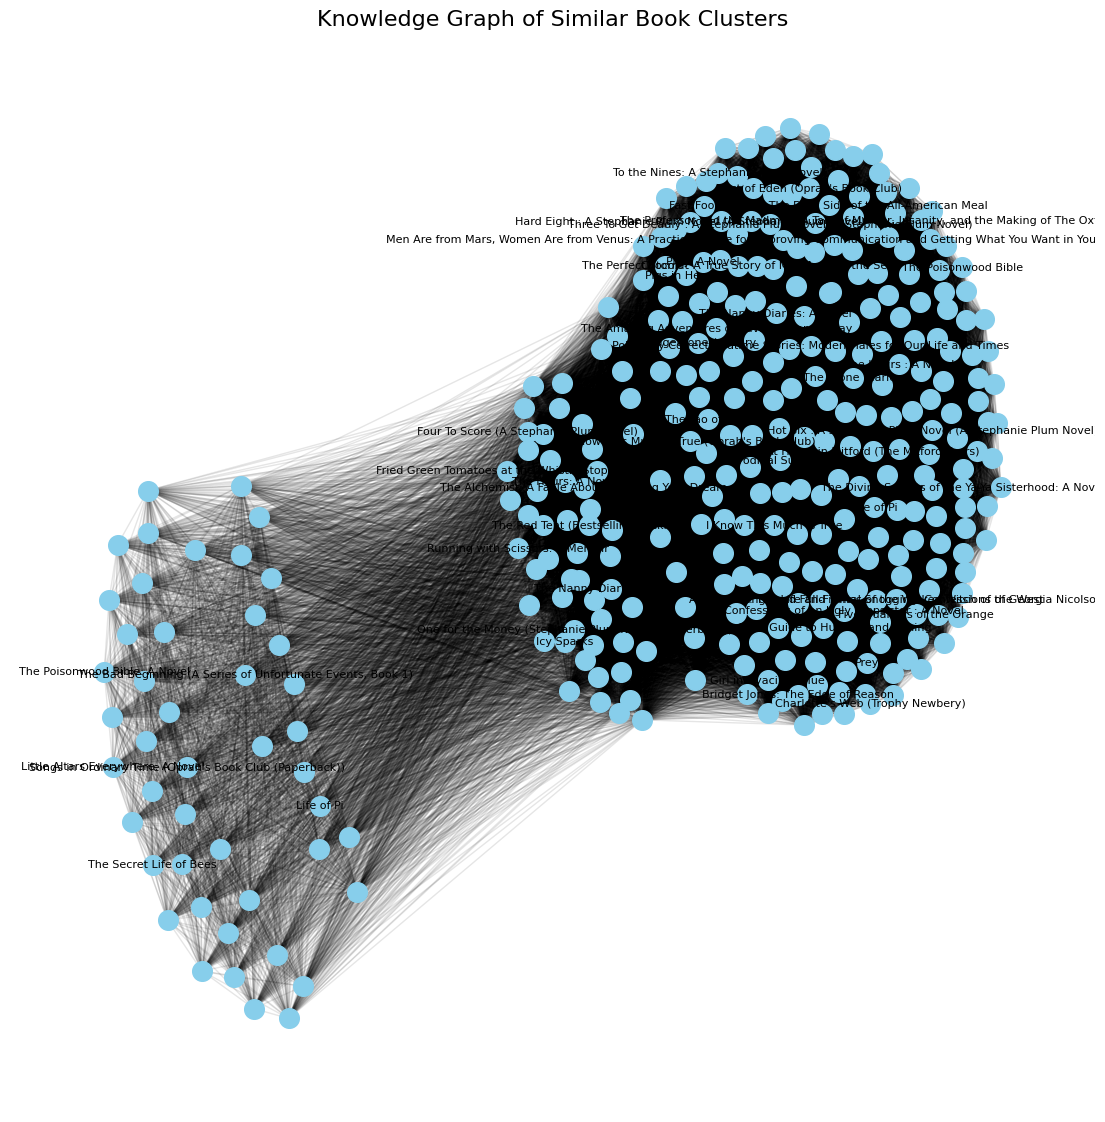

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.2)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1, alpha=0.1)

# Draw labels (limited to avoid clutter)
labels = {node: data['title'] for node, data in G.nodes(data=True)}
limited_labels = dict(list(labels.items())[:50])  # show only first 50
nx.draw_networkx_labels(G, pos, labels=limited_labels, font_size=8)

plt.title("Knowledge Graph of Similar Book Clusters", fontsize=16)
plt.axis('off')
plt.show()

In [22]:
import plotly.graph_objects as go
import networkx as nx

# Use spring layout
pos = nx.spring_layout(G, k=0.3, iterations=50)

edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(G.nodes[node]['title'])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='skyblue',
        size=10,
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Interactive Knowledge Graph of Books',
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40)))

fig.show()

In [58]:
import community  # this is the `python-louvain` package
import matplotlib.colors as mcolors

# Use the same subgraph as before
subgraph = G.subgraph(list(G.nodes)[:100])  # or any filtered subgraph

# Detect communities
partition = community.best_partition(subgraph, resolution=1.13712)

# Optional: print number of clusters
num_clusters = len(set(partition.values()))
print(f"Detected {num_clusters} clusters")

Detected 4 clusters


In [59]:
from pyvis.network import Network

# Create pyvis network
net = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')
net.from_nx(subgraph)

# Generate colors for clusters
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
cluster_colors = {cluster_id: colors[i % len(colors)] for i, cluster_id in enumerate(set(partition.values()))}

# Apply colors and labels to nodes
for node in net.nodes:
    isbn = node['id']
    cluster_id = partition[isbn]
    node['title'] = G.nodes[isbn]['title']
    node['label'] = G.nodes[isbn]['title']
    node['color'] = cluster_colors[cluster_id]  # 🎨 Apply cluster color
    
    
# Stabilize the layout and add physics controls
net.force_atlas_2based()
net.show_buttons(filter_=['physics'])
net.show("book_graph_clusters.html")

book_graph_clusters.html
